**Подключение библиотек и скриптов**

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve,  KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
import catboost as catb
from sklearn.linear_model import LogisticRegression, LinearRegression
import category_encoders as ce

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [3]:
# input
TRAIN_DATASET_PATH = './data/train.csv'
TEST_DATASET_PATH = './data/test.csv'

# output
PREP_DATASET_PATH = './Lukinykh_predictions.csv'

### Загрузка данных

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df_train.shape
df_test.shape

(2500, 16)

### Обзор данных

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Выделение целевой переменной и групп признаков**

In [6]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = [col for col in df_train.columns if str(df_train[col].dtype) != 'object']
CAT_FEATURE_NAMES = [col for col in df_train.columns if str(df_train[col].dtype) == 'object']
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()

### Анализ целевой переменной

In [7]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

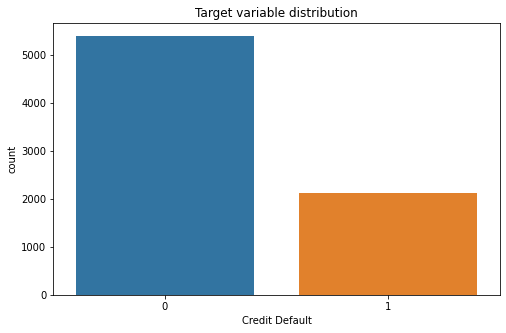

In [8]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

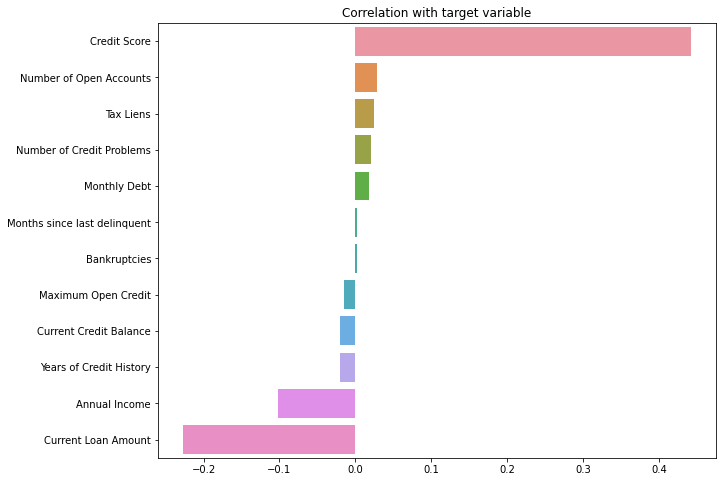

In [9]:
corr_with_target = df_train[df_train.columns.drop(TARGET_NAME).tolist() + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признаков

Видно что пропуски присутствуют в признаках:
- Annual Income
- Months since last delinquent
- Bankruptcies
- Credit Score

### Построение матрицы корреляции

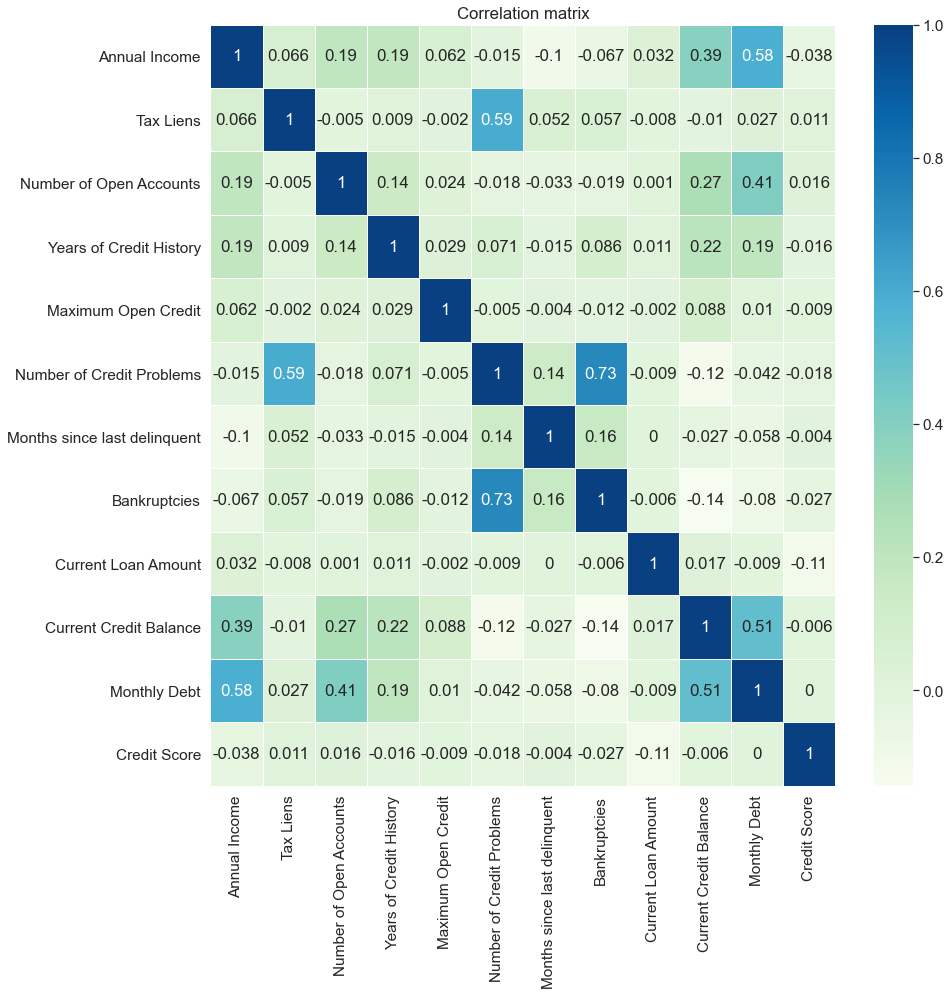

In [10]:
plt.figure(figsize = (14,14))

sns.set(font_scale=1.4)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>,
        <AxesSubplot:title={'center':'Years of Credit History'}>],
       [<AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>,
        <AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>],
       [<AxesSubplot:title={'center':'Current Loan Amount'}>,
        <AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>],
       [<AxesSubplot:title={'center':'Credit Default'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

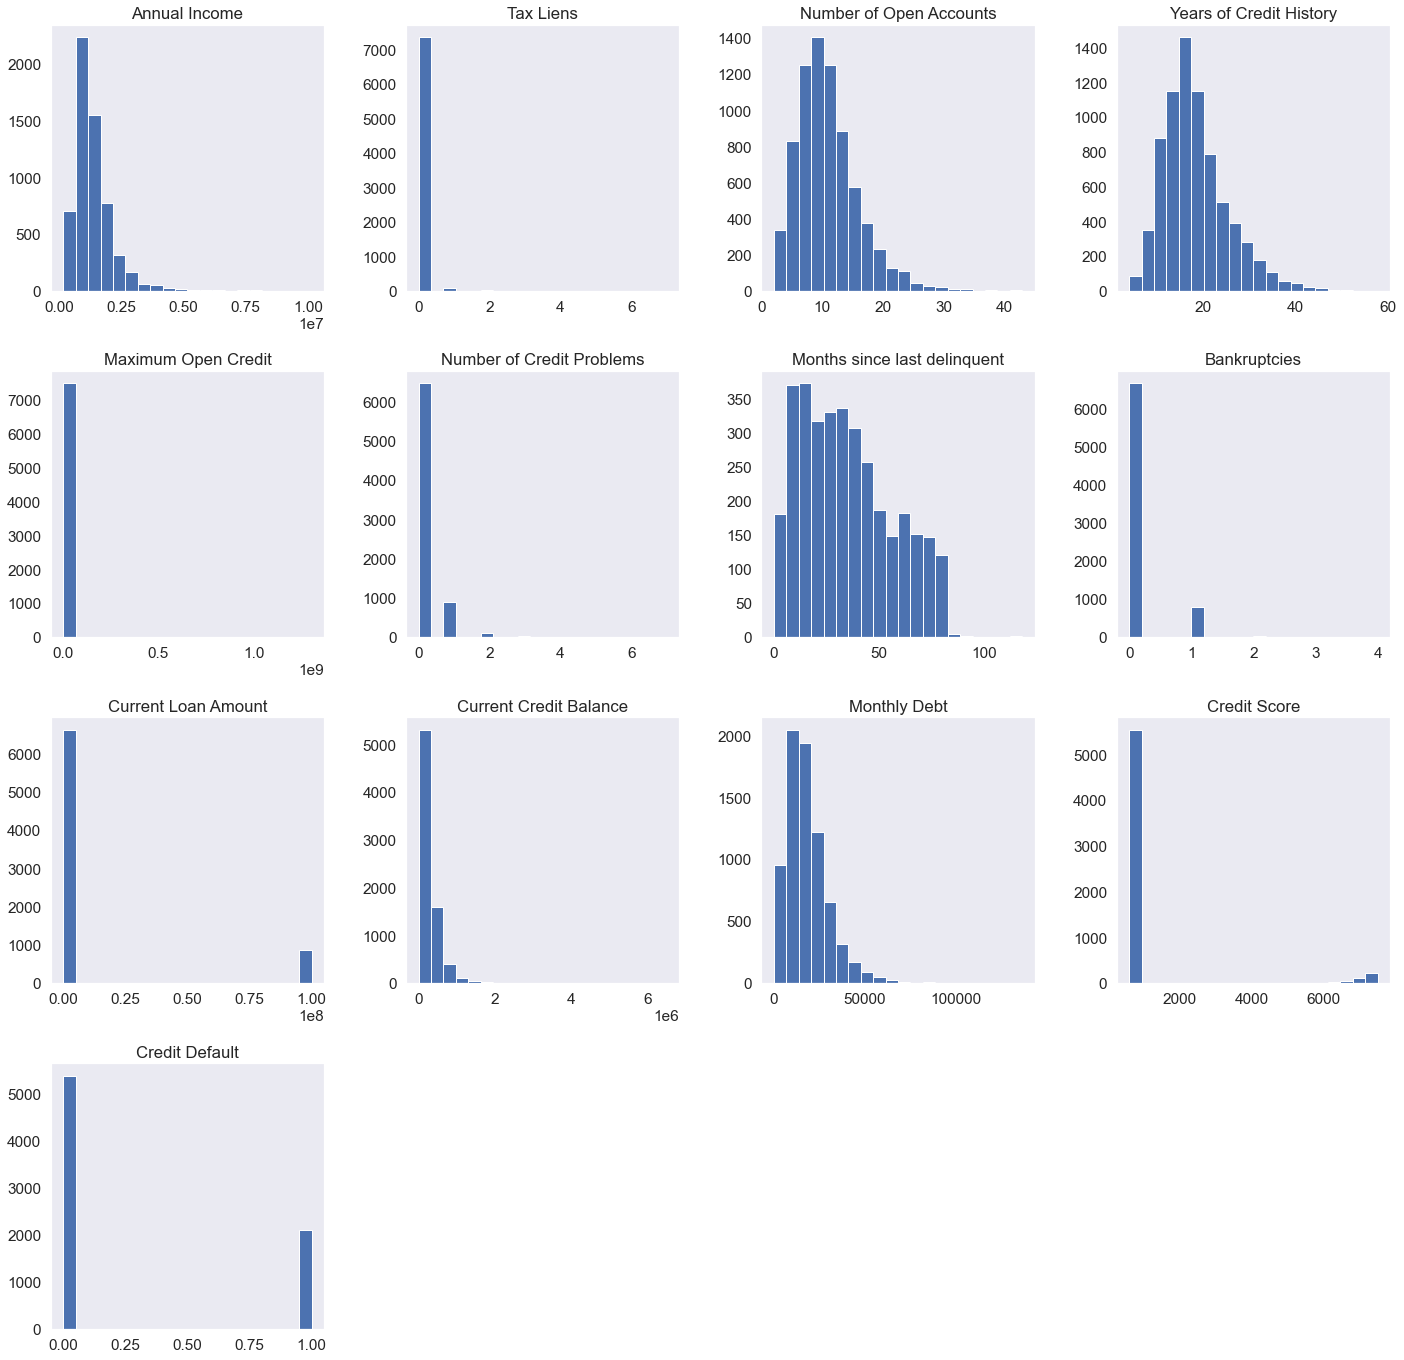

In [11]:
df_train.hist(figsize=(24, 24), bins=20, grid=False)

In [12]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.bankruptcies_mode=None
        self.purpose_frequency=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.bankruptcies_mode = X['Bankruptcies'].mode()[0]
        self.purpose_frequency = X['Purpose'].value_counts().reset_index()\
                    .rename(columns={'index':'Purpose', 'Purpose':'Purpose_frequency'})
        self.purpose_frequency['Purpose_frequency'] = self.purpose_frequency['Purpose_frequency'] / len(X['Purpose'])
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Заполнение пропусков в 'Annual Income' медианами.        
        X['Annual Income'].fillna(self.medians['Annual Income'], inplace=True)

        # Заполнение пропусков в 'Years in current job' нулями.
        X['Years in current job'].fillna(0, inplace=True)

        # Перевод значений признака 'Years in current job' из object в int32.
        X.loc[X['Years in current job'] == '< 1 year',  'Years in current job'] = 0
        X.loc[X['Years in current job'] == '1 year',  'Years in current job'] = 1
        X.loc[X['Years in current job'] == '10+ years',  'Years in current job'] = 10

        for i in range(2, 11):
            X.loc[X['Years in current job'] == f'{i} years',  'Years in current job'] = i

        X['Years in current job'] = X['Years in current job'].astype(np.int32)

        # Заполнение пропусков в 'Months since last delinquent' нулями.
        X['Months since last delinquent'].fillna(0, inplace=True)

        # Удаляем выбросы и заполняем их медианами в приззнаке 'Current Loan Amount'.
        X.loc[(X['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        max_credit = 99999999.0
        X.loc[X['Maximum Open Credit'] > max_credit, 'Maximum Open Credit'] = max_credit

        # Заполняем пропуски 'Bankruptcies' в нулями.
        X['Bankruptcies'].fillna(self.bankruptcies_mode, inplace=True)
        # Bankruptcies приводим к бинарному признаку по факту наличия банкротства
        X.loc[X['Bankruptcies'] > 0, 'Bankruptcies'] = 1
        
        # Срок кредита делаем бинарным признаком
        X['Term'] = X['Term'].replace({'Short Term':0, 'Long Term':1})
        
        # Значения признака Number of Credit Problems также привидём к бинарному виду по наличию просрочки по платежам
        X.loc[X['Number of Credit Problems'] > 0, 'Number of Credit Problems'] = 1
        
        X.loc[X['Tax Liens'] > 0, 'Tax Liens'] = 1

        X = X.merge(self.purpose_frequency, on='Purpose', how='left')

        X.loc[X['Credit Score'] >= 850, 'Credit Score'] = 850
        X['Credit Score'].fillna(self.medians['Credit Score'], inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [13]:
X = df_train[BASE_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [14]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape, X_test.shape

((5250, 17), (2250, 17))

In [15]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [16]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [17]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [18]:
CLASS_WEIGHTS = df_train[TARGET_NAME].value_counts()[0] / df_train[TARGET_NAME].value_counts()[1]
CLASS_WEIGHTS

2.549455750118315

In [19]:
params = {
    'n_estimators': 100,
    'max_depth': 3,
    'silent':True,
    'random_state':21,
    'eval_metric':'F1',
    'early_stopping_rounds':20,
    'l2_leaf_reg':10,
    'cat_features': CAT_FEATURE_NAMES,
    'class_weights': [1, CLASS_WEIGHTS]
}

model_catb = catb.CatBoostClassifier(**params)

model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      3771
           1       0.52      0.55      0.54      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.68      0.67      5250
weighted avg       0.74      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1616
           1       0.50      0.54      0.52       634

    accuracy                           0.72      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1269  347
1                290  344


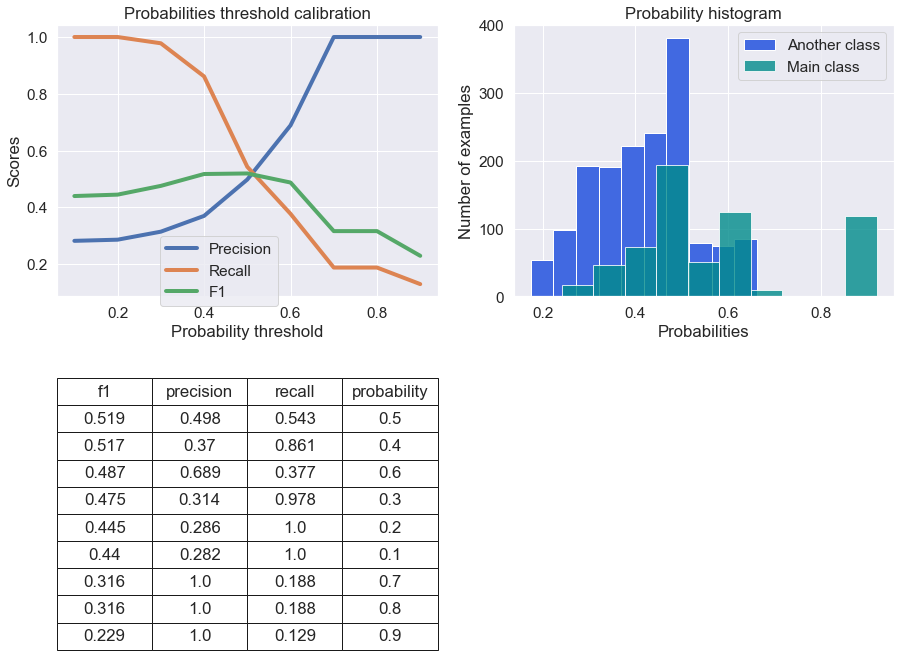

In [20]:
y_val_pred=model_catb.predict_proba(X_test)
show_proba_calibration_plots(y_val_pred[:, 1], y_test)

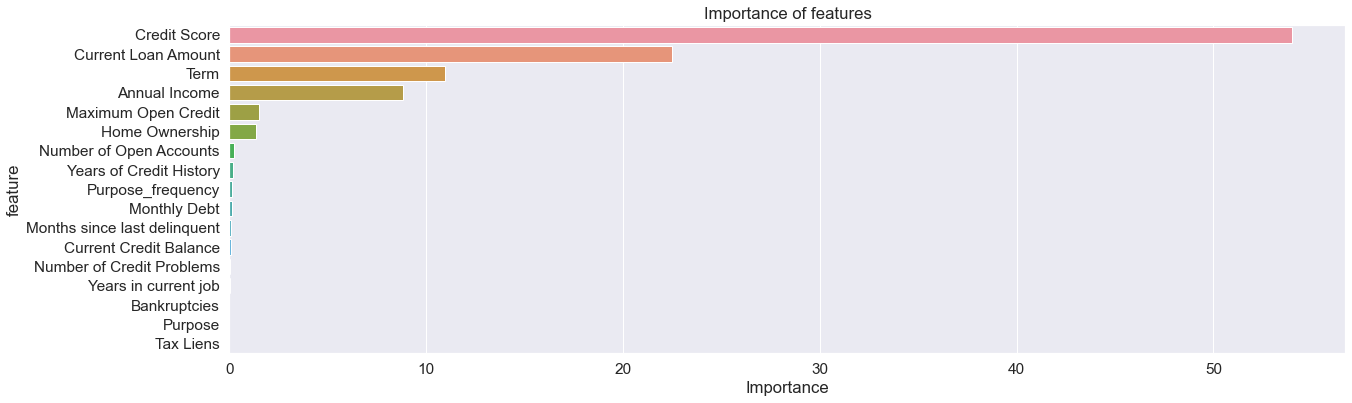

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Annual Income',
 'Maximum Open Credit',
 'Home Ownership',
 'Number of Open Accounts',
 'Years of Credit History',
 'Purpose_frequency',
 'Monthly Debt',
 'Months since last delinquent',
 'Current Credit Balance',
 'Number of Credit Problems',
 'Years in current job',
 'Bankruptcies']

In [21]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)
important_features_top

#### Кроссвалидация

In [22]:
cv_score = cross_val_score(model_catb, X_train, y_train, scoring='f1', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.55384615, 0.51211802, 0.51574803])

In [23]:
cv_score.mean()

0.527237401436517

#### Предообработка датасета

In [24]:
df_test = preprocessor.transform(df_test)

df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Purpose_frequency
0,Rent,1178712.5,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,0,162470.0,105906.0,6813.0,731.0,0.794286
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,0,78298.0,46037.0,2318.0,699.0,0.001333
2,Home Mortgage,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,0,200178.0,146490.0,18729.0,850.0,0.794286
3,Home Mortgage,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,0,217382.0,213199.0,27559.0,739.0,0.794286
4,Home Mortgage,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,1,777634.0,425391.0,42605.0,706.0,0.794286


In [25]:
df_for_model = df_test
df_for_model

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Purpose_frequency
0,Rent,1178712.5,4,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,0,162470.0,105906.0,6813.0,731.0,0.794286
1,Rent,231838.0,1,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,0,78298.0,46037.0,2318.0,699.0,0.001333
2,Home Mortgage,1152540.0,3,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,debt consolidation,0,200178.0,146490.0,18729.0,850.0,0.794286
3,Home Mortgage,1220313.0,10,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,0,217382.0,213199.0,27559.0,739.0,0.794286
4,Home Mortgage,2340952.0,6,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,debt consolidation,1,777634.0,425391.0,42605.0,706.0,0.794286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,0,311278.0,162735.0,15046.0,745.0,0.794286
2496,Home Mortgage,1178712.5,2,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,0,468512.0,1439269.0,32996.0,731.0,0.794286
2497,Home Mortgage,1171806.0,2,0.0,48.0,12.8,1706430.0,0.0,0.0,0.0,debt consolidation,0,430496.0,676438.0,36912.0,695.0,0.794286
2498,Rent,723520.0,10,0.0,14.0,28.8,945780.0,0.0,0.0,0.0,debt consolidation,0,257774.0,391248.0,13506.0,744.0,0.794286


#### Предсказание целевой переменной

In [26]:
y_pred_output = model_catb.predict(df_for_model)

### Сохранение результата

In [27]:
result = pd.DataFrame({'Id': np.arange(2500), 'Credit Default': y_pred_output})

In [28]:
result.to_csv(PREP_DATASET_PATH, index=False)

In [29]:
df_sample = pd.read_csv(PREP_DATASET_PATH)

predictions = pd.DataFrame(index=df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions

,Credit Default
Id,
0,0
1,1
2,1
3,0
4,1
...,...
2495,0
2496,0
2497,0
